# Predictive Modeling

In [17]:
!pip install google-cloud-bigquery google-cloud-storage
!pip install xgboost scikit-learn bayesian-optimization
!pip install shap xgboost

In [2]:
from google.colab import auth
auth.authenticate_user()

In [18]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Initialize BigQuery client
project_id = "bigdatabowl2025"
client = bigquery.Client(project=project_id, location='us-central1')

# Loading final_df after initial runs

In [4]:
# Define your query
query = """
SELECT * FROM `bigdatabowl2025.bdb_tables.final_aggregated_data`
"""

# Execute the query and convert the result to a DataFrame
final_df = client.query(query).to_dataframe()

# Display the first few rows
print(final_df.shape)
print(final_df.head())


(16062, 35)
       gameId  playId  rb_snap_motion  ...  pff_manZone  fb_present  rb_present
0  2022091100    1952               0  ...         None         0.0         1.0
1  2022091100    4068               0  ...         None         0.0         1.0
2  2022091100    4131               0  ...         None         0.0         1.0
3  2022091101    2227               0  ...         None         0.0         1.0
4  2022091101    4128               0  ...         None         0.0         1.0

[5 rows x 35 columns]


In [5]:
# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(
    # aggregated_df_final,
    final_df,
    columns=['offenseFormation', 'receiverAlignment', 'pff_passCoverage', 'pff_manZone'],
    drop_first=True
)

# Feature and target separation
X = X_encoded.drop(columns=['target_rush', 'gameId', 'playId'])
# y = aggregated_df_final['target_rush'].astype(int)
y = final_df['target_rush'].astype(int)

# Verify the result
print(X.head())
print(y.head())

   rb_snap_motion  fb_snap_motion  ...  pff_manZone_Other  pff_manZone_Zone
0               0               0  ...              False             False
1               0               0  ...              False             False
2               0               0  ...              False             False
3               0               0  ...              False             False
4               0               0  ...              False             False

[5 rows x 62 columns]
0    0
1    0
2    0
3    1
4    0
Name: target_rush, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Convert 'gameClock' to seconds if it is in 'MM:SS' format
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return 0  # Handle any NaN values as 0
    minutes, seconds = map(int, time_str.split(":"))
    return minutes * 60 + seconds

X_train['gameClock'] = X_train['gameClock'].apply(convert_to_seconds)
X_test['gameClock'] = X_test['gameClock'].apply(convert_to_seconds)

In [8]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
xgb.set_config(verbosity=0)

# Define Bayesian Optimization for XGBoost
def xgb_cv(max_depth, learning_rate, n_estimators, colsample_bytree, subsample):
    model = xgb.XGBClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_result = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
    return cv_result.mean()

# Parameter bounds for optimization
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 500),
    'colsample_bytree': (0.3, 0.9),
    'subsample': (0.5, 1.0)
}

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.7451    | 0.5247    | 0.2857    | 8.124     | 339.5     | 0.578     |
| 2         | 0.7762    | 0.3936    | 0.02684   | 9.063     | 340.4     | 0.854     |
| 3         | 0.7477    | 0.3124    | 0.2913    | 8.827     | 184.9     | 0.5909    |
| 4         | 0.771     | 0.41      | 0.09823   | 6.673     | 272.8     | 0.6456    |
| 5         | 0.7804    | 0.6671    | 0.05045   | 5.045     | 246.5     | 0.728     |
| 6         | 0.7785    | 0.6952    | 0.03192   | 5.057     | 246.5     | 0.7593    |
| 7         | 0.7633    | 0.4829    | 0.2608    | 4.682     | 247.2     | 0.6948    |
| 8         | 0.7521    | 0.7344    | 0.2487    | 5.566     | 246.5     | 0.5839    |
| 9         | 0.7786    | 0.8203    | 0.08025   | 4.824     | 246.7     | 0.9004    |
| 10        | 0.777     | 0.6242    | 0.03752   | 4.63

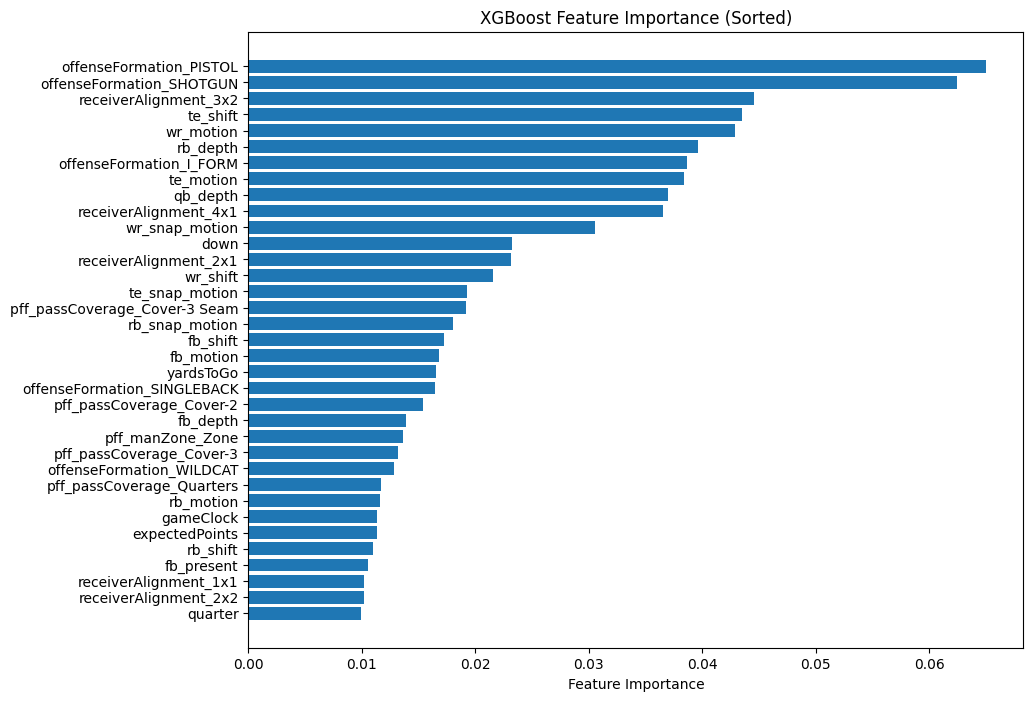

In [9]:
from bayes_opt import BayesianOptimization
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train final XGBoost model with optimized parameters
final_model = xgb.XGBClassifier(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    use_label_encoder=False,
    eval_metric='logloss'
)

final_model.fit(X_train, y_train)

# Get feature importance
xgb_importances = final_model.feature_importances_

# Sort features and importances in descending order
sorted_indices = np.argsort(xgb_importances)[::-1]  # Sort indices in descending order
sorted_features = X_train.columns[sorted_indices]
sorted_importances = xgb_importances[sorted_indices]

# Plot feature importance in descending order
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:35], sorted_importances[:35])  # Display top 25 features
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Select the top 25 features
top_features = sorted_features[:35]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [10]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_top, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_test_top)
y_pred_lgb_proba = lgb_model.predict_proba(X_test_top)[:, 1]

# Evaluate LightGBM
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_lgb_proba)
print(f"LightGBM Accuracy: {accuracy_lgb}")
print(f"LightGBM ROC-AUC: {roc_auc_lgb}")

# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_top, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_top)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_top)[:, 1]

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(f"XGBoost ROC-AUC: {roc_auc_xgb}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4677, number of negative: 6566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 11243, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415992 -> initscore=-0.339248
[LightGBM] [Info] Start training from score -0.339248
LightGBM Accuracy: 0.7727744345299855
LightGBM ROC-AUC: 0.8510175219257259
XGBoost Accuracy: 0.7711143390744968
XGBoost ROC-AUC: 0.8429691429528814


In [11]:
results = {
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_lgb, accuracy_xgb],
    "ROC-AUC": [roc_auc_lgb, roc_auc_xgb]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

      Model  Accuracy   ROC-AUC
0  LightGBM  0.772774  0.851018
1   XGBoost  0.771114  0.842969


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search_lgb = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

grid_search_lgb.fit(X_train_top, y_train)
print(f"Best LightGBM Params: {grid_search_lgb.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3742, number of negative: 5252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1369
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.416055 -> initscore=-0.338989
[LightGBM] [Info] Start training from score -0.338989
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3741, number of negative: 5253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_col_wise=true` to remove the ove

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_distributions=param_grid_xgb,
    scoring='roc_auc',
    n_iter=20,
    cv=5,
    verbose=1
)

random_search_xgb.fit(X_train_top, y_train)
print(f"Best XGBoost Params: {random_search_xgb.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [14]:
# Step 1: Store models and their metrics
models = {
    "LightGBM": {"model": lgb_model, "accuracy": accuracy_lgb, "roc_auc": roc_auc_lgb},
    "XGBoost": {"model": xgb_model, "accuracy": accuracy_xgb, "roc_auc": roc_auc_xgb}
}

# Step 2: Determine the best model based on ROC-AUC
best_model_name = max(models, key=lambda k: models[k]["roc_auc"])  # Select model with the highest ROC-AUC
final_model = models[best_model_name]["model"]

print(f"The best model is: {best_model_name} with ROC-AUC: {models[best_model_name]['roc_auc']}")

# Step 3: Use the winning model for predictions
y_pred_final = final_model.predict(X_test_top)
y_pred_final_proba = final_model.predict_proba(X_test_top)[:, 1]

# Step 4: Evaluate the final model on the test set
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

accuracy_final = accuracy_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_pred_final_proba)

print(f"Final Model Test Accuracy: {accuracy_final}")
print(f"Final Model Test ROC-AUC: {roc_auc_final}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

The best model is: LightGBM with ROC-AUC: 0.8510175219257259
Final Model Test Accuracy: 0.7727744345299855
Final Model Test ROC-AUC: 0.8510175219257259
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      2761
           1       0.75      0.71      0.73      2058

    accuracy                           0.77      4819
   macro avg       0.77      0.76      0.77      4819
weighted avg       0.77      0.77      0.77      4819



In [19]:
import joblib
joblib.dump(final_model, 'final_lightgbm_model.pkl')

['final_lightgbm_model.pkl']

Accuracy: 0.7727744345299855
ROC-AUC: 0.8510175219257259


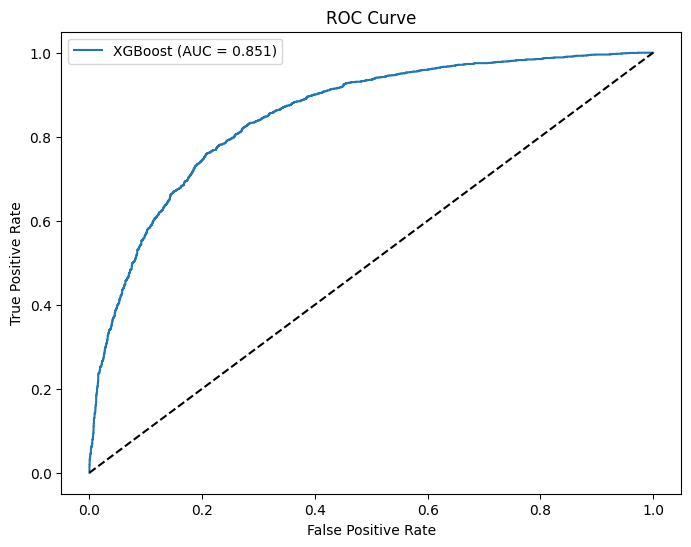

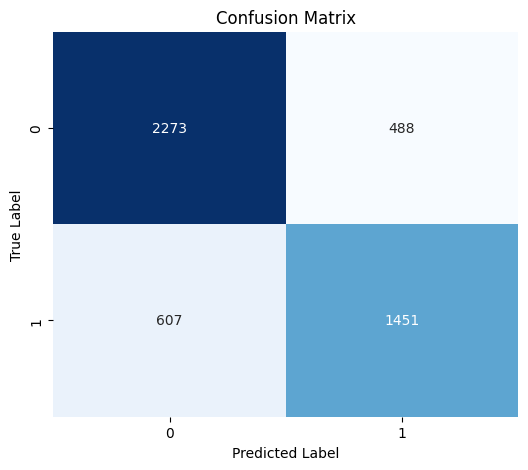

In [15]:
import seaborn as sns

# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred_final)

print(f"Accuracy: {accuracy_final}")
print(f"ROC-AUC: {roc_auc_final}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_final_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="XGBoost (AUC = {:.3f})".format(roc_auc_final))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


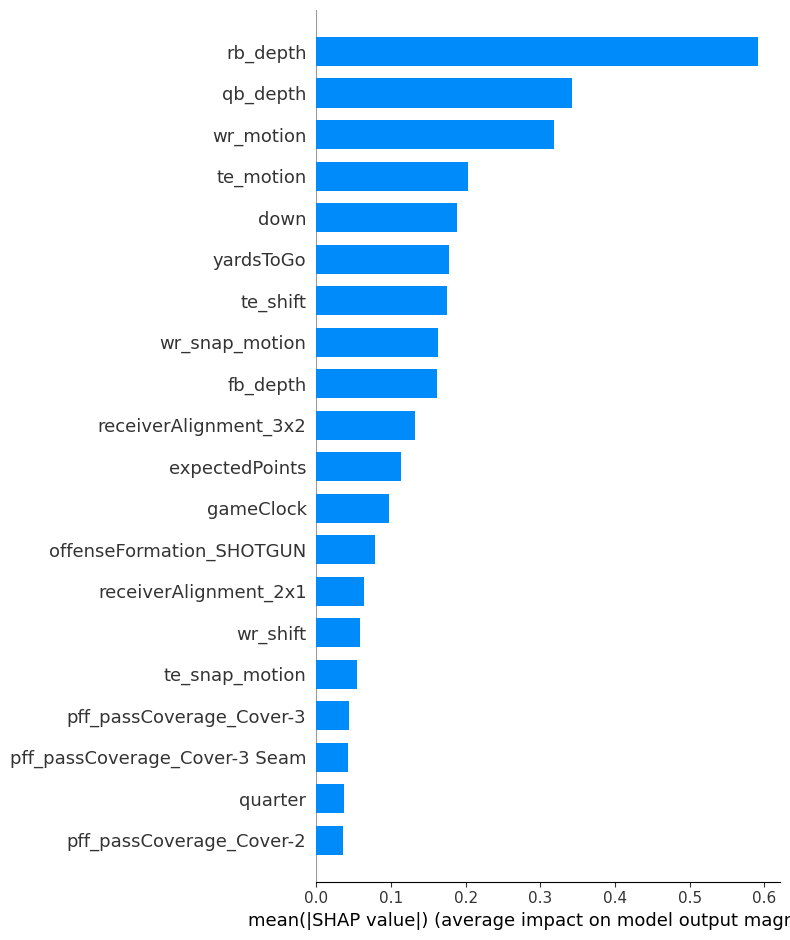

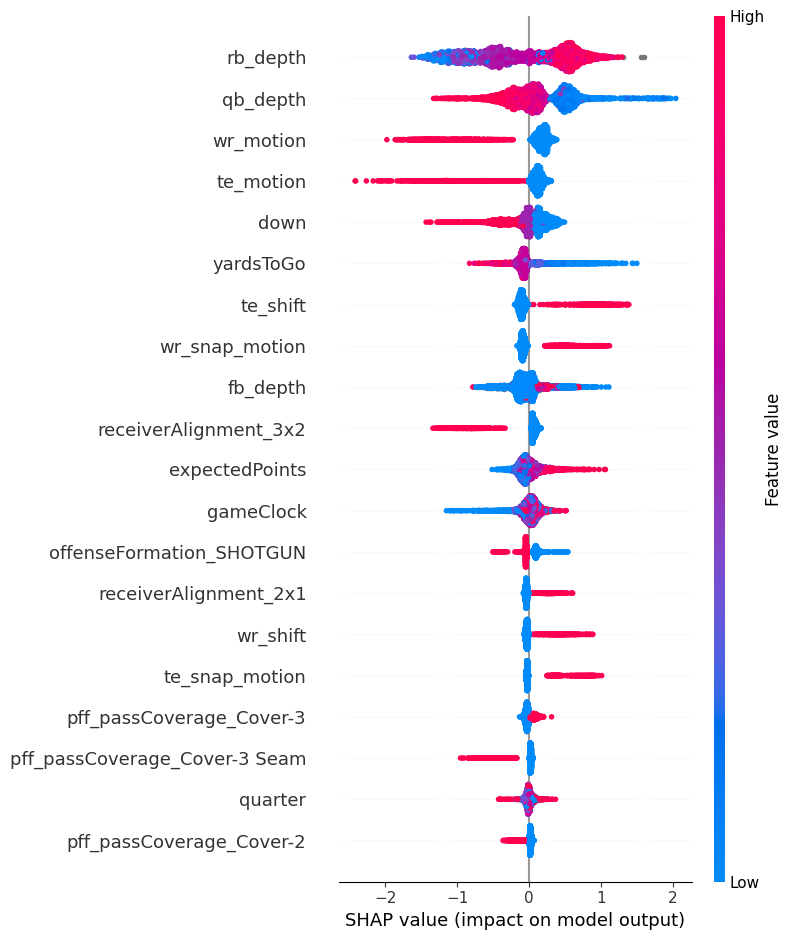

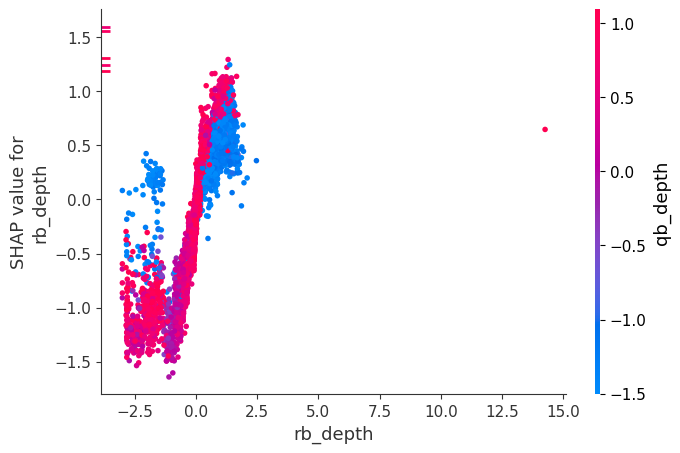

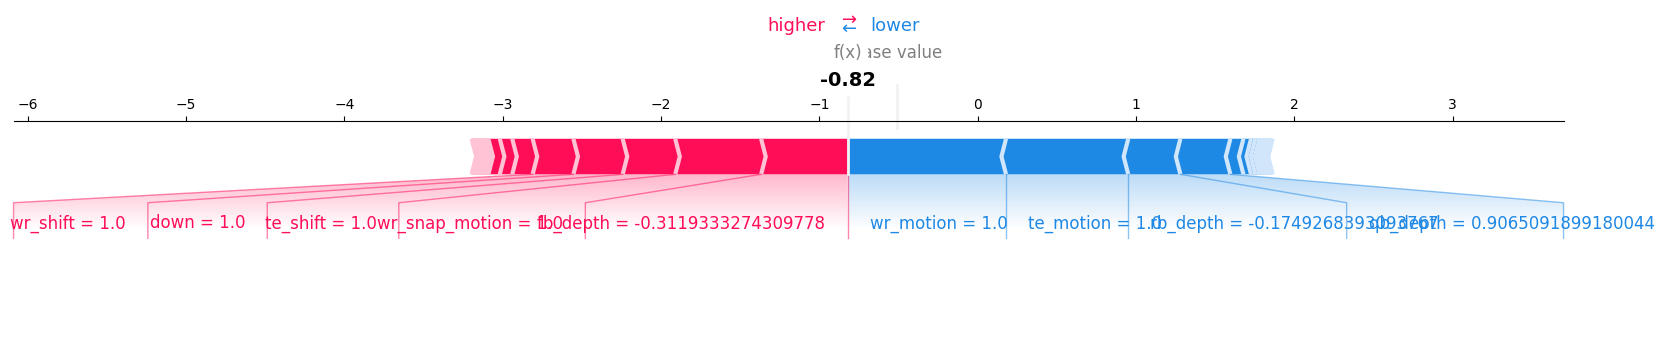

In [21]:
# Step 1: Initialize the SHAP Explainer for LightGBM
explainer = shap.TreeExplainer(final_model)

# Step 2: Compute SHAP Values for the Test Data
shap_values = explainer.shap_values(X_test_top)

# Step 3: Summary Plot (Global Feature Importance)
# Visualize global feature importance across the dataset
shap.summary_plot(shap_values, X_test_top, plot_type="bar")

# Step 4: Detailed Summary Plot
# Shows the distribution of SHAP values for each feature
shap.summary_plot(shap_values, X_test_top)

# Step 5: Dependence Plot for 'rb_depth' vs. 'target_rush'
# Ensure 'rb_depth' is a feature in X_test_top
if 'rb_depth' in X_test_top.columns:
    shap.dependence_plot('rb_depth', shap_values, X_test_top)
else:
    print("Feature 'rb_depth' not found in the test dataset.")

# Step 6: Force Plot (Individual Prediction)
# Ensure compatibility with scalar expected_value
shap.force_plot(
    explainer.expected_value,  # Scalar expected value
    shap_values[0],            # SHAP values for the first row
    X_test_top.iloc[0, :],     # First row of test data
    matplotlib=True
)